# 4/22 프로젝트

## ControlNet으로 조건을 준 이미지 생성하기 

### C1 류지호

## 1. 환경 설정 및 기본 라이브러리 설치

In [1]:
# Stable Diffusion 및 ControlNet 관련 라이브러리 설치
!pip install -qq diffusers==0.31
!pip install controlnet-aux==0.0.1

# 필요한 라이브러리 임포트
import torch
import numpy as np
import cv2
from PIL import Image
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler
from diffusers.utils import load_image
from controlnet_aux import OpenposeDetector

     |████████████████████████████████| 64 kB 3.0 MB/s             


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]


===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /opt/conda/lib/python3.9/site-packages/bitsandbytes/libbitsandbytes_cpu.so
/opt/conda/lib/python3.9/site-packages/bitsandbytes/libbitsandbytes_cpu.so: undefined symbol: cadam32bit_grad_fp32
CUDA_SETUP: WARNING! libcudart.so not found in any environmental path. Searching in backup paths...
CUDA SETUP: Highest compute capability among GPUs detected: 7.5
CUDA SETUP: Detected CUDA version 113
CUDA SETUP: Loading binary /opt/conda/lib/python3.9/site-packages/bitsandbytes/libbitsandbytes_cpu.so...


/opt/conda/lib/python3.9/site-packages/bitsandbytes/cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "
/opt/conda/lib/python3.9/site-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('/usr/local/nvidia/lib')}
  warn(msg)
/opt/conda/lib/python3.9/site-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: /usr/local/nvidia/lib:/usr/local/nvidia/lib64 did not contain ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0'] as expected! Searching further paths...
  warn(msg)
/opt/conda/lib/python3.9/site-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('443'), Posix

## 2. 윤곽선 검출(Canny Edge Detection)을 활용한 이미지 생성

### 2.1 이미지 불러오기 및 윤곽선 검출

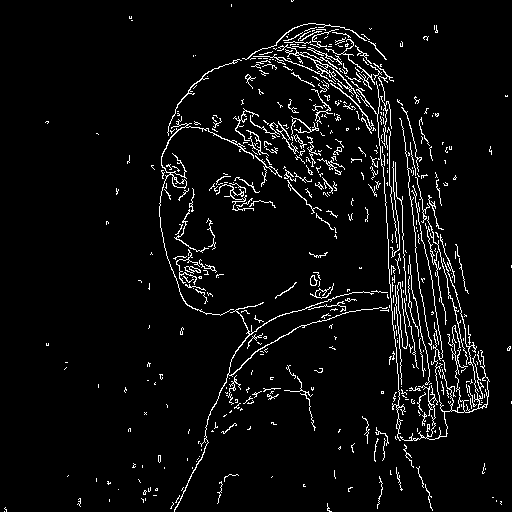

In [2]:
# 이미지 불러오기
image = load_image(
    "https://hf.co/datasets/huggingface/documentation-images/resolve/main/diffusers/input_image_vermeer.png"
)

# 이미지를 NumPy 배열로 변환
image_np = np.array(image)

# 윤곽선 검출 파라미터 설정
low_threshold = 100
high_threshold = 200

# Canny 알고리즘으로 윤곽선 검출
canny_result = cv2.Canny(image_np, low_threshold, high_threshold)
canny_result = canny_result[:, :, None]
canny_result = np.concatenate([canny_result, canny_result, canny_result], axis=2)
canny_image = Image.fromarray(canny_result)

# 윤곽선 이미지 확인
canny_image

### 2.2 ControlNet 모델 로드 및 이미지 생성

config.json:   0%|          | 0.00/920 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.45G [00:00<?, ?B/s]

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


  0%|          | 0/30 [00:00<?, ?it/s]

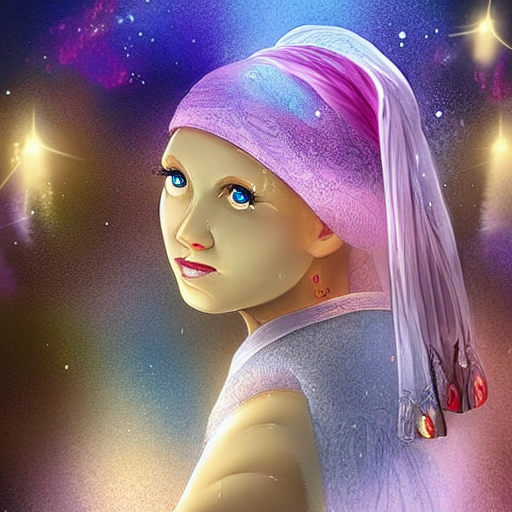

In [3]:
# Canny ControlNet 모델 로드
canny_controlnet = ControlNetModel.from_pretrained(
    "lllyasviel/sd-controlnet-canny", 
    torch_dtype=torch.float16
)

# Stable Diffusion 파이프라인 설정
canny_pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", 
    controlnet=canny_controlnet, 
    torch_dtype=torch.float16
)

# 스케줄러 설정
canny_pipe.scheduler = UniPCMultistepScheduler.from_config(canny_pipe.scheduler.config)
canny_pipe = canny_pipe.to("cuda")

# 재현성을 위한 시드 설정
generator = torch.manual_seed(42)

# 프롬프트 설정 및 이미지 생성
prompt = "A magical fairy tale castle in a enchanted forest, highly detailed, fantasy art, vibrant colors"
negative_prompt = "blurry, low quality, distorted, deformed"

# 이미지 생성
canny_output = canny_pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=30,
    generator=generator,
    image=canny_image,
    guidance_scale=7.5
).images[0]

# 생성된 이미지 저장 및 출력
canny_output.save("/aiffel/aiffel/canny_output.png")
canny_output

## 3. 인체 자세 검출(Openpose)을 활용한 이미지 생성

### 3.1 이미지 불러오기 및 자세 검출

body_pose_model.pth:   0%|          | 0.00/209M [00:00<?, ?B/s]

cuda


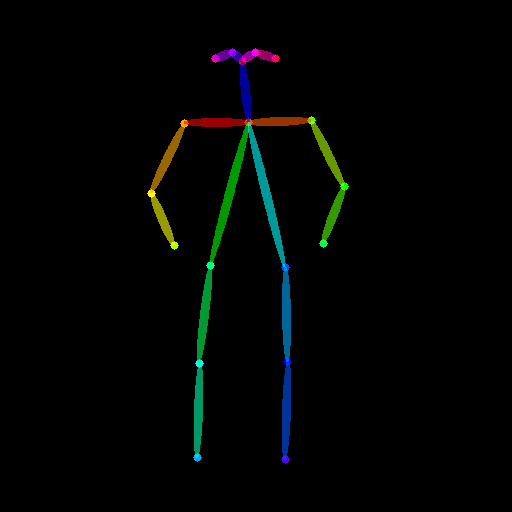

In [4]:
# 인체 이미지 불러오기
pose_image = load_image(
    "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/person.png"
)

# Openpose 모델 로드 및 자세 검출
openpose = OpenposeDetector.from_pretrained("lllyasviel/ControlNet")
openpose_image = openpose(pose_image)

# 자세 검출 결과 확인
openpose_image

### 3.2 ControlNet 모델 로드 및 이미지 생성

config.json:   0%|          | 0.00/920 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.45G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


  0%|          | 0/30 [00:00<?, ?it/s]

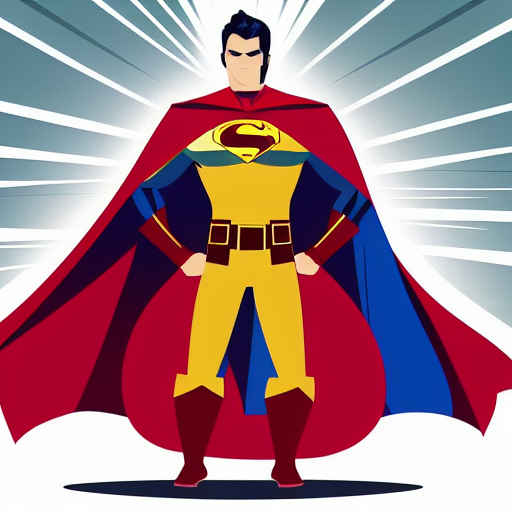

In [5]:
# Openpose ControlNet 모델 로드
openpose_controlnet = ControlNetModel.from_pretrained(
    "lllyasviel/sd-controlnet-openpose", 
    torch_dtype=torch.float16
)

# Stable Diffusion 파이프라인 설정
openpose_pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", 
    controlnet=openpose_controlnet, 
    torch_dtype=torch.float16
)

# 스케줄러 설정
openpose_pipe.scheduler = UniPCMultistepScheduler.from_config(openpose_pipe.scheduler.config)
openpose_pipe = openpose_pipe.to("cuda")

# 재현성을 위한 시드 설정
generator = torch.manual_seed(123)

# 프롬프트 설정
prompt = "A superhero with a flowing cape, dynamic pose, comic book style, vibrant colors"
negative_prompt = "blurry, low quality, distorted, deformed, ugly, bad anatomy"

# 이미지 생성
openpose_output = openpose_pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=30,
    generator=generator,
    image=openpose_image,
    guidance_scale=7.5
).images[0]

# 생성된 이미지 저장 및 출력
openpose_output.save("/aiffel/aiffel/openpose_output.png")
openpose_output

## 4. 윤곽선 검출과 인체 자세 검출을 결합한 이미지 생성

### 4.1 윤곽선 검출 이미지 준비

In [6]:
# 이미지 불러오기
canny_base_image = load_image(
    "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/person.png"
)

# 이미지를 NumPy 배열로 변환
canny_np = np.array(canny_base_image)

# 윤곽선 검출 파라미터 설정
low_threshold = 100
high_threshold = 200

# 인체 감지 포즈를 넣어줄 가운데 부분을 지워줍니다
zero_start = canny_np.shape[1] // 4
zero_end = zero_start + canny_np.shape[1] // 2
canny_np[:, zero_start:zero_end] = 0

# 윤곽선 검출
canny_result = cv2.Canny(canny_np, low_threshold, high_threshold)
canny_result = canny_result[:, :, None]
canny_result = np.concatenate([canny_result, canny_result, canny_result], axis=2)
canny_prepared = Image.fromarray(canny_result)

### 4.2 인체 자세 검출 이미지 준비

In [7]:
# 인체 이미지 불러오기
pose_base_image = load_image(
    "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/person.png"
)

# Openpose 모델로 자세 검출
openpose = OpenposeDetector.from_pretrained("lllyasviel/ControlNet")
openpose_prepared = openpose(pose_base_image)

cuda


### 4.3 두 개의 ControlNet 모델 결합 및 이미지 생성

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


  0%|          | 0/30 [00:00<?, ?it/s]

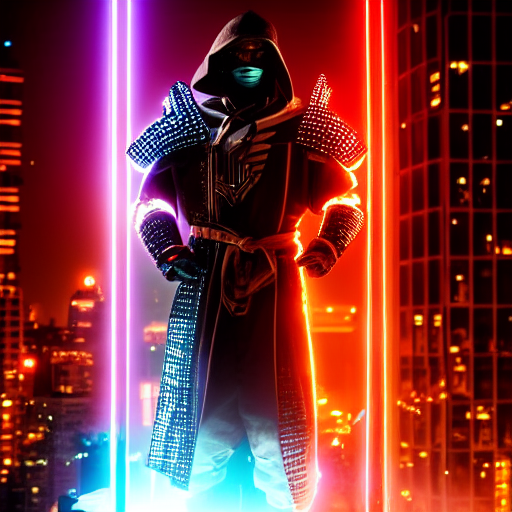

In [8]:
# 두 개의 ControlNet 모델 로드
canny_controlnet = ControlNetModel.from_pretrained(
    "lllyasviel/sd-controlnet-canny", 
    torch_dtype=torch.float16
)

openpose_controlnet = ControlNetModel.from_pretrained(
    "lllyasviel/sd-controlnet-openpose", 
    torch_dtype=torch.float16
)

# 두 개의 ControlNet 모델을 리스트로 결합
controlnets = [openpose_controlnet, canny_controlnet]

# 결합된 ControlNet으로 파이프라인 설정
multi_pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", 
    controlnet=controlnets, 
    torch_dtype=torch.float16
)

# 스케줄러 설정
multi_pipe.scheduler = UniPCMultistepScheduler.from_config(multi_pipe.scheduler.config)
multi_pipe = multi_pipe.to("cuda")

# 재현성을 위한 시드 설정
generator = torch.manual_seed(789)

# 프롬프트 설정
prompt = "A cyberpunk warrior in a neon-lit futuristic city, detailed armor, glowing elements, dynamic pose"
negative_prompt = "blurry, low quality, distorted, deformed, ugly, bad anatomy"

# 이미지 리스트 준비
images = [openpose_prepared, canny_prepared]

# 이미지 생성
multi_output = multi_pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=30,
    generator=generator,
    image=images,
    guidance_scale=7.5
).images[0]

# 생성된 이미지 저장 및 출력
multi_output.save("/aiffel/aiffel/multi_controlnet_output.png")
multi_output

## 5. 추가 실험: 다양한 프롬프트와 하이퍼파라미터 조정

  0%|          | 0/40 [00:00<?, ?it/s]

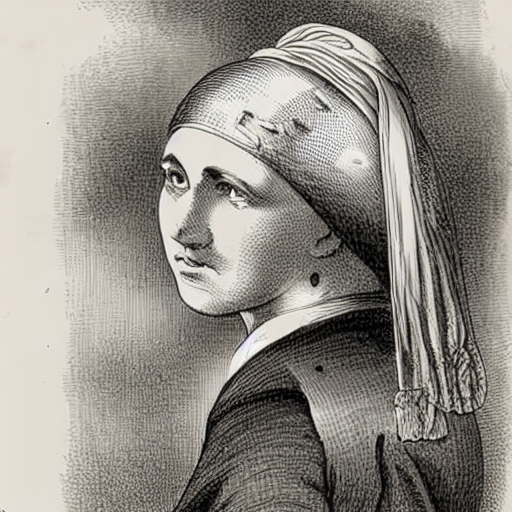

In [9]:
# 윤곽선 검출 기반 이미지 생성 - 다른 프롬프트와 파라미터
generator = torch.manual_seed(456)
prompt = "A steampunk airship floating above Victorian London, detailed mechanical parts, steam and gears"
negative_prompt = "blurry, low quality, distorted, deformed"

canny_output_2 = canny_pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=40,  # 스텝 수 증가
    generator=generator,
    image=canny_image,
    guidance_scale=8.5  # 가이던스 스케일 증가
).images[0]

canny_output_2.save("/aiffel/aiffel/canny_output_2.png")
canny_output_2

  0%|          | 0/50 [00:00<?, ?it/s]

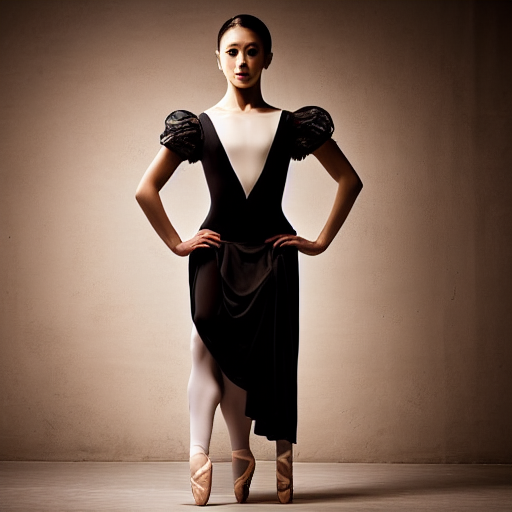

In [10]:
# 인체 자세 검출 기반 이미지 생성 - 다른 프롬프트와 파라미터
generator = torch.manual_seed(789)
prompt = "A ballet dancer in an elegant pose, flowing dress, dramatic lighting, professional photography"
negative_prompt = "blurry, low quality, distorted, deformed, ugly, bad anatomy"

openpose_output_2 = openpose_pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=50,  # 스텝 수 증가
    generator=generator,
    image=openpose_image,
    guidance_scale=9.0  # 가이던스 스케일 증가
).images[0]

openpose_output_2.save("/aiffel/aiffel/openpose_output_2.png")
openpose_output_2

  0%|          | 0/45 [00:00<?, ?it/s]

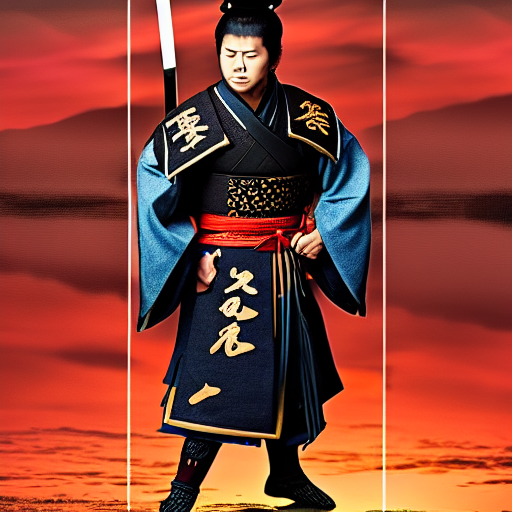

In [11]:
# 결합된 ControlNet으로 이미지 생성 - 다른 프롬프트와 파라미터
generator = torch.manual_seed(101)
prompt = "A samurai warrior in combat stance, traditional Japanese armor, cherry blossoms falling, dramatic sunset"
negative_prompt = "blurry, low quality, distorted, deformed, ugly, bad anatomy"

multi_output_2 = multi_pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=45,  # 스텝 수 조정
    generator=generator,
    image=images,
    guidance_scale=8.0  # 가이던스 스케일 조정
).images[0]

multi_output_2.save("/aiffel/aiffel/multi_controlnet_output_2.png")
multi_output_2

## 회고

### 1. ControlNet이 test 프롬프트뿐만 아니라 image 형태의 조건부 입력도 함께 사용하여서, 더욱 구체적이고 정확한 이미지를 생성하는 데에 '제어가 가능하다'는 점이 인상깊다.

### 2. 윤곽선 검출, 인체 자세 검출 을 기반으로 여러 이미지를 생성한 결과가 신기했다.

### 3. 원하는 이미지를 얻기 위해 프롬프트가 굉장히 잘 작성되어야 한다는 것과, 하이퍼파라미터를 조정함에 따라 생성 품질과 속도, 내용이 휙휙 바뀌는 것도 기억에 남는다.